# Task 4: Understand speech recognition and speech-to-text conversion

## 1. Design a simple neural network to recognize spoken digits: Free Spoken Digit Dataset contains recordings of spoken digits in wave files at 8kHz. This dataset contains 50 recordings for every 10 digits per every 6 speakers. This dataset in total contains 3000 recordings in English pronunciations. 

## 2. Design a program to convert the given dataset MP3 file into text. Show your code and results in your report. Program can be done with open-source python libraries, e.g. “speech_recognition” or “pydub”.

## 3. Establish your own input dataset, and convert your own speech data into text. For example, by recording:“ I am having fun with human robot interaction class.” Show your code and results in your report.

## 5. Write down the problems you encountered during the experiment, the solutions, and your experiences.

/var/folders/f9/skl499nn3ng638tcn445mjg40000gn/T/ipykernel_3106/3179254224.py:35: DeprecationWarning: Importing blackman from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.blackman' or the convenience function 'scipy.signal.get_window' instead.
  f, t, Sxx = signal.spectrogram(Audiodata, fs,window = signal.blackman(N),nfft=N)


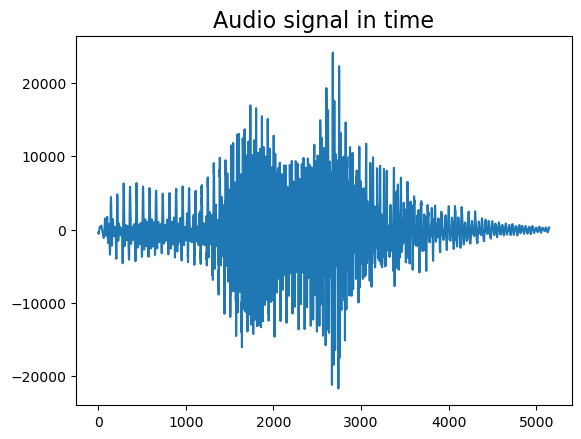

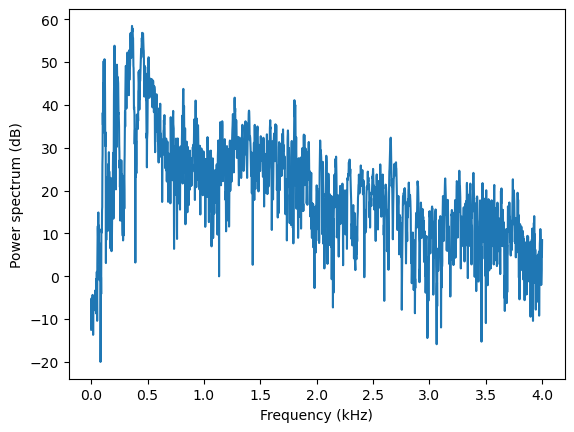

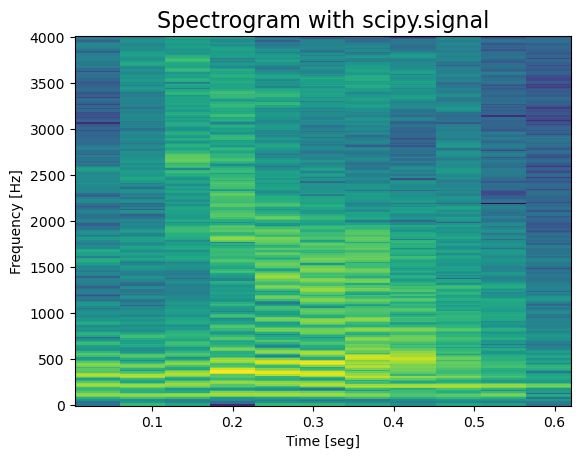

In [1]:
from scipy.io import wavfile # scipy library to read wav files
import numpy as np

AudioName = "0_jackson_0.wav" # Audio File
fs, Audiodata = wavfile.read(AudioName)

# Plot the audio signal in time
import matplotlib.pyplot as plt
plt.plot(Audiodata)
plt.title('Audio signal in time',size=16)

# spectrum
from scipy.fftpack import fft # fourier transform
n = len(Audiodata) 
AudioFreq = fft(Audiodata)
AudioFreq = AudioFreq[0:int(np.ceil((n+1)/2.0))] #Half of the spectrum
MagFreq = np.abs(AudioFreq) # Magnitude
MagFreq = MagFreq / float(n)
# power spectrum
MagFreq = MagFreq**2
if n % 2 > 0: # ffte odd 
    MagFreq[1:len(MagFreq)] = MagFreq[1:len(MagFreq)] * 2
else:# fft even
    MagFreq[1:len(MagFreq) -1] = MagFreq[1:len(MagFreq) - 1] * 2 

plt.figure()
freqAxis = np.arange(0,int(np.ceil((n+1)/2.0)), 1.0) * (fs / n);
plt.plot(freqAxis/1000.0, 10*np.log10(MagFreq)) #Power spectrum
plt.xlabel('Frequency (kHz)'); plt.ylabel('Power spectrum (dB)');


#Spectrogram
from scipy import signal
N = 512 #Number of point in the fft
f, t, Sxx = signal.spectrogram(Audiodata, fs,window = signal.blackman(N),nfft=N)
plt.figure()
plt.pcolormesh(t, f,10*np.log10(Sxx)) # dB spectrogram
#plt.pcolormesh(t, f,Sxx) # Lineal spectrogram
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [seg]')
plt.title('Spectrogram with scipy.signal',size=16);

plt.show()

In [5]:
import deeplake
ds = deeplake.load("hub://activeloop/spoken_mnist")
ds.visualize()

/

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist


/

hub://activeloop/spoken_mnist loaded successfully.


In [2]:
# 导入所需的库
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

# 使用deeplake来导入free-spoken-digit-dataset数据集
import hub
ds = hub.load("hub://activeloop/spoken_mnist")

# 定义一些超参数
batch_size = 32 # 批次大小
num_epochs = 10 # 训练轮数
learning_rate = 0.01 # 学习率
num_classes = 10 # 类别数

# 定义数据集类，用于加载和处理数据
class SpokenDigitDataset(data.Dataset):
    def __init__(self, ds, mode):
        # ds是deeplake导入的数据集对象，mode是训练模式或者测试模式
        self.ds = ds
        self.mode = mode
        
        # 根据模式划分训练集和测试集的索引范围，官方规定测试集为前10%的录音，即0-4号录音，训练集为后90%的录音，即5-49号录音
        if mode == "train":
            self.start_index = 5
            self.end_index = 49
        elif mode == "test":
            self.start_index = 0
            self.end_index = 4
    
    def __len__(self):
        # 返回数据集的长度，即录音数目
        return len(self.ds)
    
    def __getitem__(self, index):
        # 根据索引返回一个数据样本，包括图像和标签
        
        # 从deeplake数据集对象中获取录音和标签
        audio = self.ds.audio[index].numpy()
        label = self.ds.labels[index].numpy()
        
        # 将录音转换为spectrum image，返回图像数组和频率范围和时间范围（可选）
        image, freqs, times = librosa.feature.melspectrogram(audio, sr=8000, n_mels=128)
        
        # 对图像数组进行对数变换，提高对比度
        image = librosa.power_to_db(image, ref=np.max)
        
        # 将图像数组转换为torch张量，并增加一个维度作为通道数（灰度图为1）
        image = torch.from_numpy(image).unsqueeze(0)
        
        # 返回图像和标签
        return image, label

# 创建训练集和测试集对象
train_dataset = SpokenDigitDataset(ds, mode="train")
test_dataset = SpokenDigitDataset(ds, mode="test")

# 创建训练集和测试集的数据加载器，用于批次化和打乱数据
train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 定义CNN模型类，包含3个卷积层和一些其他层
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        # 定义第一个卷积层，输入通道数为1，输出通道数为16，卷积核大小为3x3，步长为1，填充为1
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        
        # 定义第一个池化层，使用最大池化，池化核大小为2x2，步长为2
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 定义第二个卷积层，输入通道数为16，输出通道数为32，卷积核大小为3x3，步长为1，填充为1
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        
        # 定义第二个池化层，使用最大池化，池化核大小为2x2，步长为2
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 定义第三个卷积层，输入通道数为32，输出通道数为64，卷积核大小为3x3，步长为1，填充为1
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        
        # 定义第三个池化层，使用最大池化，池化核大小为2x2，步长为2
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # 定义一个全连接层，输入特征数为64x16x8，输出特征数为256
        self.fc1 = nn.Linear(in_features=64*16*8, out_features=256)
        
        # 定义一个激活层，使用ReLU函数
        self.relu = nn.ReLU()
        
        # 定义一个输出层，输入特征数为256，输出特征数为类别数
        self.out = nn.Linear(in_features=256, out_features=num_classes)
    
    def forward(self, x):
        # 前向传播函数，定义模型的计算流程
        
        # 通过第一个卷积层和第一个池化层
        x = self.pool1(self.conv1(x))
        
        # 通过第二个卷积层和第二个池化层
        x = self.pool2(self.conv2(x))
        
        # 通过第三个卷积层和第三个池化层
        x = self.pool3(self.conv3(x))
        
        # 将张量展平为一维向量
        x = x.view(-1, 64*16*8)
        
        # 通过全连接层和激活层
        x = self.relu(self.fc1(x))
        
        # 通过输出层，得到最终的预测结果
        x = self.out(x)
        
        # 返回预测结果
        return x

# 创建CNN模型对象
model = CNN()

# 定义损失函数，使用交叉熵损失
criterion = nn.CrossEntropyLoss()

# 定义优化器，使用随机梯度下降法（SGD）
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 训练模型
for epoch in range(num_epochs):
    # 初始化训练损失和准确率
    train_loss = 0.0
    train_acc = 0.0
    
    # 遍历训练集的每个批次
    for images, labels in train_loader:
        
        # 将图像和标签转换为适合模型的类型和形状（如果需要）
        images = images.float()
        labels = labels.long()
        
        # 清零优化器的梯度缓存
        optimizer.zero_grad()
        
        # 前向传播，得到预测结果
        outputs = model(images)
        
        # 计算损失值
        loss = criterion(outputs, labels)
        
        # 反向传播，计算梯度值
        loss.backward()
        
        # 更新模型参数
        optimizer.step()
        
        # 累加训练损失值
        train_loss += loss.item()
        
        # 计算预测的类别，即概率最大的那个类别
        _, preds = torch.max(outputs, 1)
        
        # 计算并累加训练准确率值
        train_acc += torch.sum(preds == labels).item() / len(labels)
    
    # 计算并打印训练集的平均损失值和准确率值
    train_loss = train_loss / len(train_loader)
    train_acc

-

Opening dataset in read-only mode as you don't have write permissions.


\

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/spoken_mnist


|

hub://activeloop/spoken_mnist loaded successfully.


ReadSampleFromChunkError: Unable to read sample at index 743 from chunk 'audio/chunks/c4ebeb5c' in tensor audio.